# GDAS - first-look data analysis for continuous recordings

This notebook contains basic data visualization and analysis of the data collected with Stryde nodes at KAUST as part of the GDAS project on Dec 7 2023.

The dataset is acquired as follows:

- <font color='blue'>Receivers</font>

    1 line of 89 buried receivers, equally spaced by 2m for a total lenght of 178m.

    1 receiver placed near (and following) the source

- <font color='red'>Sources</font>

    13 sources on the right side of the receiver line at Point 2001, 2005, 2009, 2013, 2017, 2021, 2025, 2029, 2037, 2045, 2069, 2077, 2085 (8m or 16m distance)

    10 shots per source

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pylops
import matplotlib.pyplot as plt

from matplotlib.colors import SymLogNorm
from pylops.signalprocessing import FFT2D

from pystryde.reader import *
from pystryde.preproc import *
from pystryde.cmap import cmaps
from pystryde.visual import *

## Analysis for shot

In [2]:
# Selected shot

# GOOD!
ishot = 0 
ishotmaster = 0
filterd= False
tlims = (20, 200)

# GOOD!
ishot = 1
ishotmaster = 0
filterd= False
tlims = (20, 600)

# NOT SO GOO!!
ishot = 2
ishotmaster = 4
filterd= True
tlims = (20, 300)

# GOOD!
ishot = 3
ishotmaster = 0
filterd = False
tlims = (5, 230)

"""
# GOOD!
ishot = 4
ishotmaster = 0
filterd= False
tlims = (10, 200)

# GOOD!
ishot = 5
ishotmaster = 0
filterd = True
tlims = (10, 200)

# GOOD!
ishot = 6
ishotmaster = 0
filterd = False
tlims = (10, 200)

# LAST SHOT DOES NOT ALIGN...
ishot = 7
ishotmaster = 0
filterd = True
tlims = (1, 250)

# NOT WORKING!!
ishot = 8
ishotmaster = 4
filterd = True
tlims = (50, 300)

# GOOD!
ishot = 9
ishotmaster = 0
filterd = False
tlims = (10, 300)

# NOT WORKING!!
ishot = 10
ishotmaster = 5
filterd = True
tlims = (30, 250)

# NOT WORKING (LAST 2 SHOTS OFF!!)
ishot = 11
ishotmaster = 0
filterd = True
tlims = (50, 300)

# GOOD!
#ishot = 12
#ishotmaster = 0
#filterd = True
#tlims = (10, 250)
"""

t0s = [0.12, 0.08, 0.095, 0.04, 0.052, 0.070, 0.062, 0.027, 0.13, 0.030, 0.089, 0.129, 0.075]

Data shape: (10, 1, 13, 90, 4000)
Working with shot 2013.0


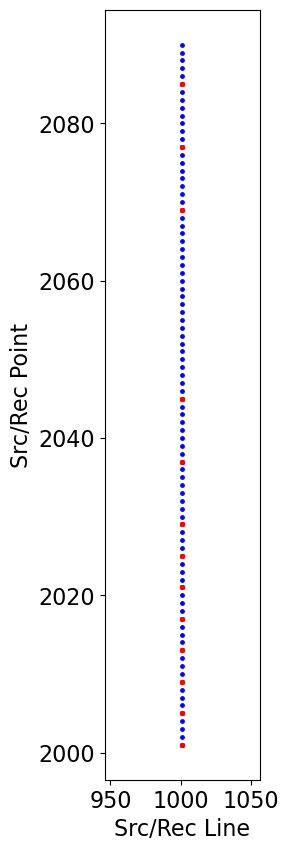

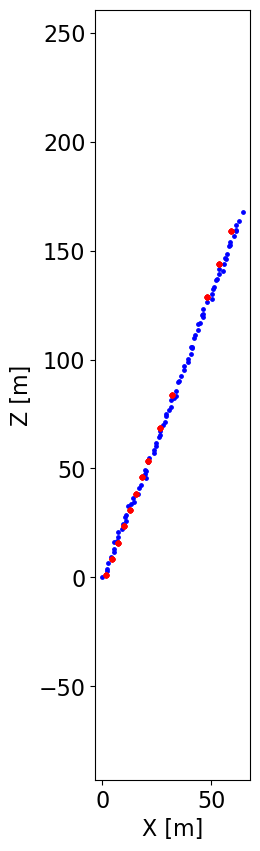

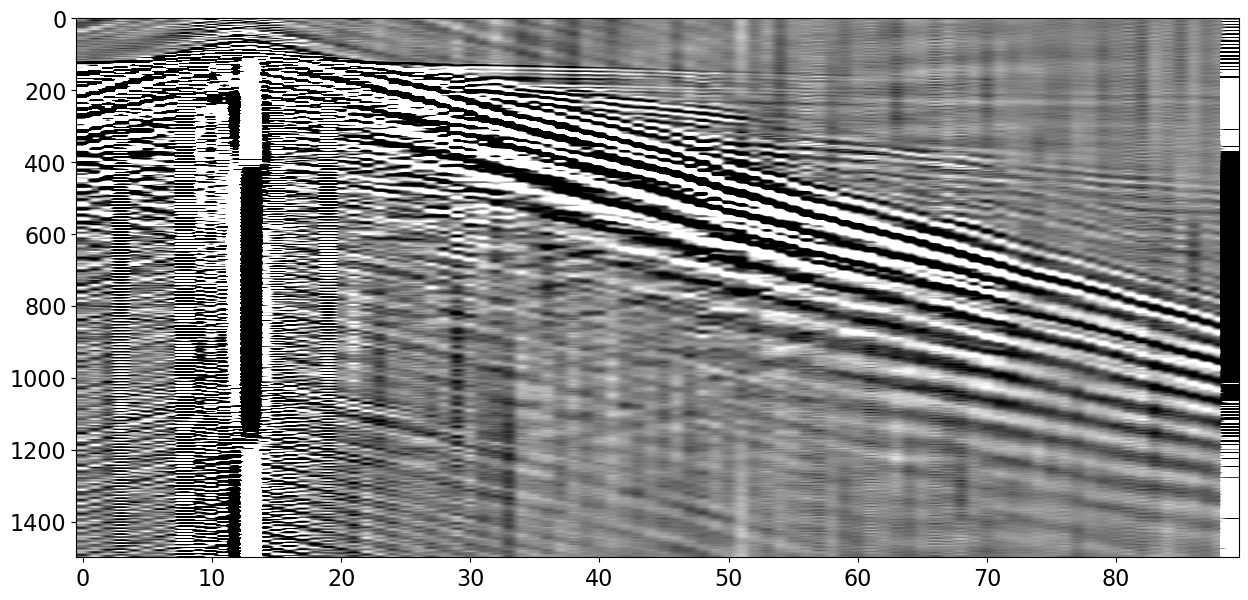

In [3]:
fs = strydeshots('/mnt/datawaha_dig/Data/STRYDE/GDAS_07_12_2023//ShotGathers/')
fs.interpret()
fs.getshot()

fs.recx = fs.recx.astype(np.float32)
fs.recy = fs.recy.astype(np.float32)
fs.recx[fs.recx==0] = np.nan
fs.recx[np.isnan(fs.recx)] = np.nanmean(fs.recx)
fs.recy[fs.recy==0] = np.nan
fs.recy[np.isnan(fs.recy)] = np.nanmean(fs.recy)

print('Data shape:', fs.data.shape)
print(f'Working with shot {fs.srcpoint_axis[ishot]}')

fs.plotgeom(coords=False, figsize=(2, 10))
fig, ax = fs.plotgeom(local=True, figsize=(2, 10))
ax.axis('equal')
plt.savefig('Figs/localsurveygeometry.png', dpi=200)

plt.figure(figsize=(15,7))
plt.imshow(fs.data[2, 0, ishot, :, :1500].T, cmap='gray', vmin=-1e-3, vmax=1e-3)
plt.axis('tight');

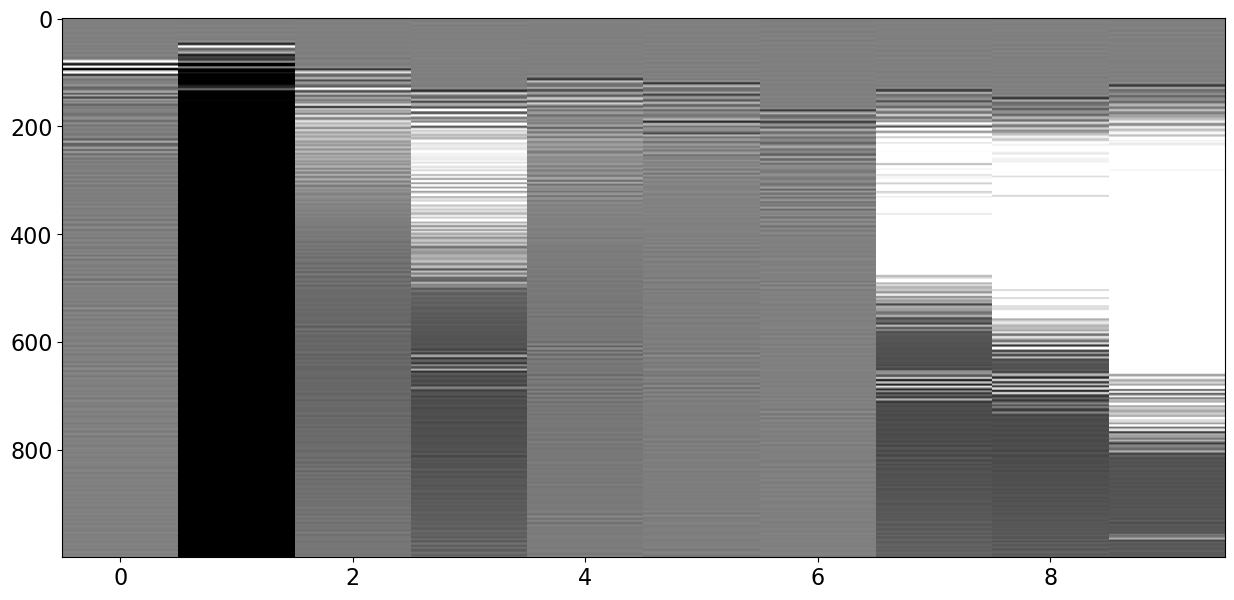

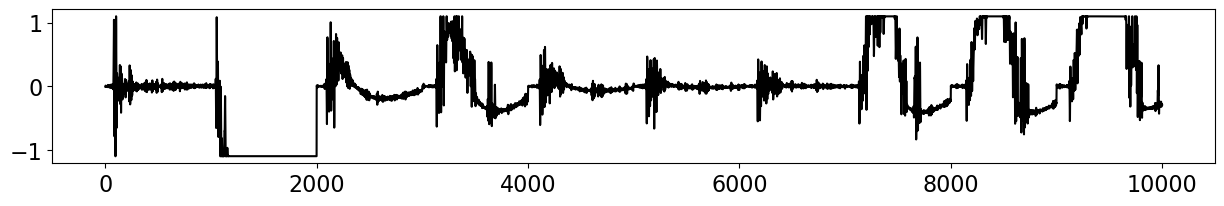

In [4]:
plt.figure(figsize=(15,7))
plt.imshow(fs.data[:, 0, ishot, -1, :1000].T, cmap='gray', interpolation='none', vmin=-1e0, vmax=1e0)
plt.axis('tight');

plt.figure(figsize=(15,2))
plt.plot(fs.data[:, 0, ishot, -1, :1000].ravel(), 'k');

### Improve data alignment via cross-correlation

Let's start with a single shot location. We will use the traces at the closest receiver to find the best alignment

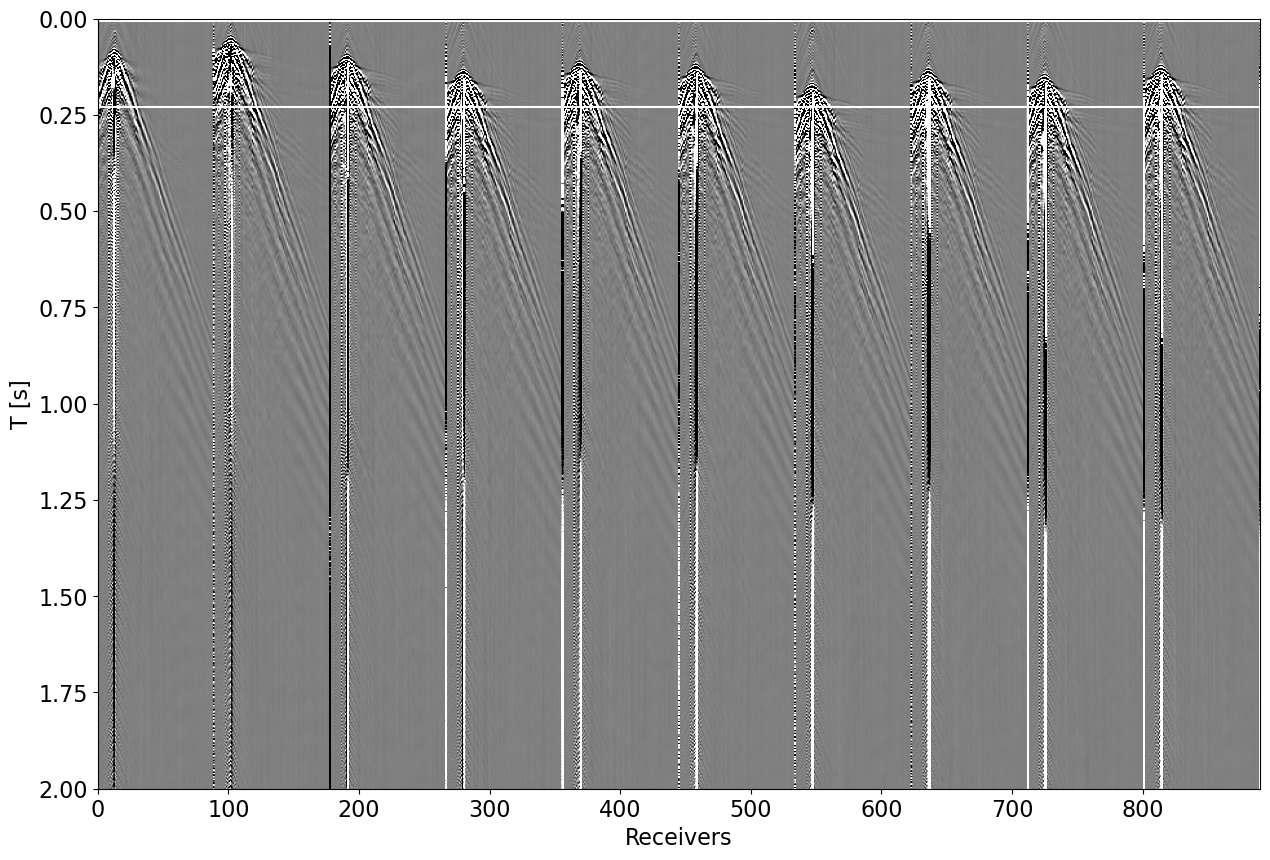

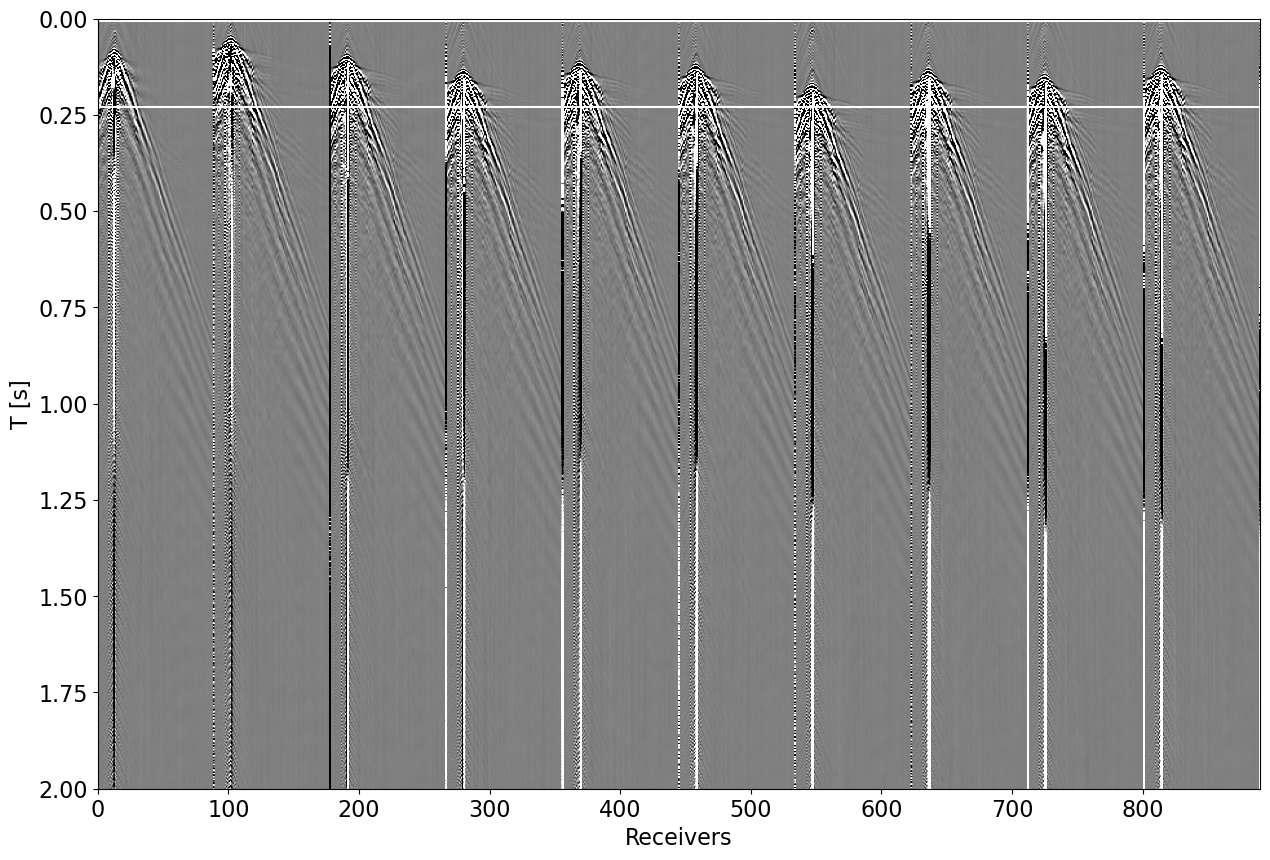

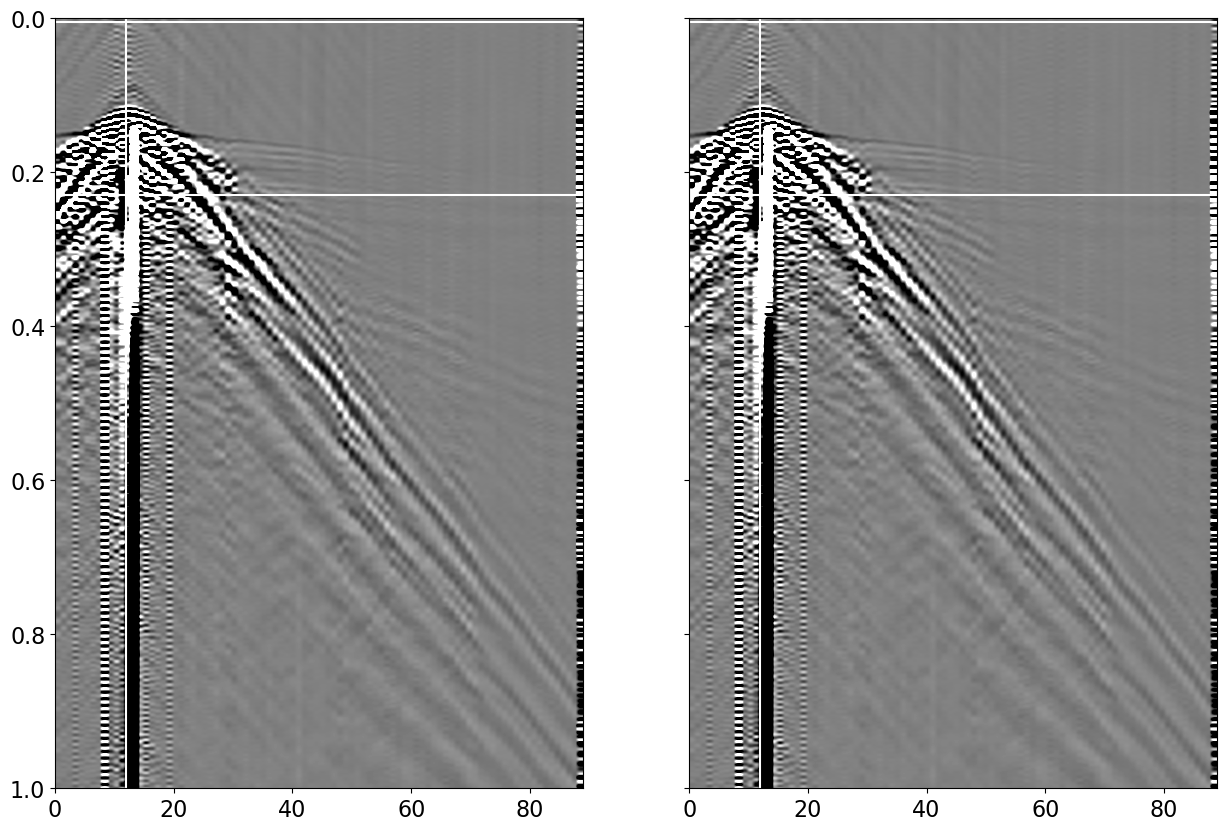

In [5]:
data = fs.data.copy()

# trace to use for alignment
irecalign = np.where(fs.recpoint == fs.srcpoint_axis[ishot])[0][0]

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(data[:, 0, ishot].reshape(-1, fs.nt).T, 
          cmap='gray', vmin=-0.01, vmax=0.01, extent=(0, 89*10, fs.t[-1], 0))
ax.axhline(fs.t[tlims[0]], color='w')
ax.axhline(fs.t[tlims[1]], color='w')
ax.axis('tight')
ax.set_xlabel('Receivers')
ax.set_ylabel('T [s]')
ax.set_ylim(2., 0);

# Filter away low freq noise in zero-offset
if filterd:
    filtdata = filterdata(11, 20, 120, fs.dt, data)[-1]
else:
    filtdata = data.copy()
    
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(filtdata[:, 0, ishot].reshape(-1, fs.nt).T, 
          cmap='gray', vmin=-0.01, vmax=0.01, extent=(0, 89*10, fs.t[-1], 0))
ax.axhline(fs.t[tlims[0]], color='w')
ax.axhline(fs.t[tlims[1]], color='w')
ax.axis('tight')
ax.set_xlabel('Receivers')
ax.set_ylabel('T [s]')
ax.set_ylim(2., 0);

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15, 10))
axs[0].imshow(data[5, 0, ishot].reshape(-1, fs.nt).T, 
          cmap='gray', vmin=-0.01, vmax=0.01, extent=(0, 89, fs.t[-1], 0))
axs[0].axhline(fs.t[tlims[0]], color='w')
axs[0].axhline(fs.t[tlims[1]], color='w');
axs[0].axvline(irecalign, color='w');
axs[0].axis('tight')
axs[1].imshow(filtdata[5, 0, ishot].reshape(-1, fs.nt).T, 
          cmap='gray', vmin=-0.01, vmax=0.01, extent=(0, 89, fs.t[-1], 0))
axs[1].axhline(fs.t[tlims[0]], color='w')
axs[1].axhline(fs.t[tlims[1]], color='w');
axs[1].axvline(irecalign, color='w');
axs[1].axis('tight')
axs[1].set_ylim(1., 0);

(9, 1, 13, 90, 4000)
Indices of max aligment: [224 176 137 158 150 100 137 123 146]
Indices of max aligment after shifts: [224 125 131 224 224 224 224 224 224]
Indices of max aligment after shifts (for otherdata): [224 125 131 224 224 224 224 224 224]


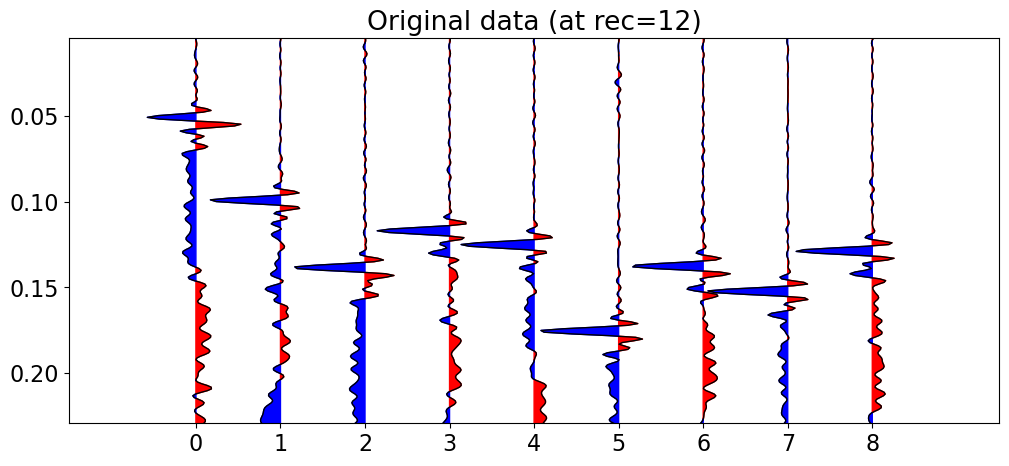

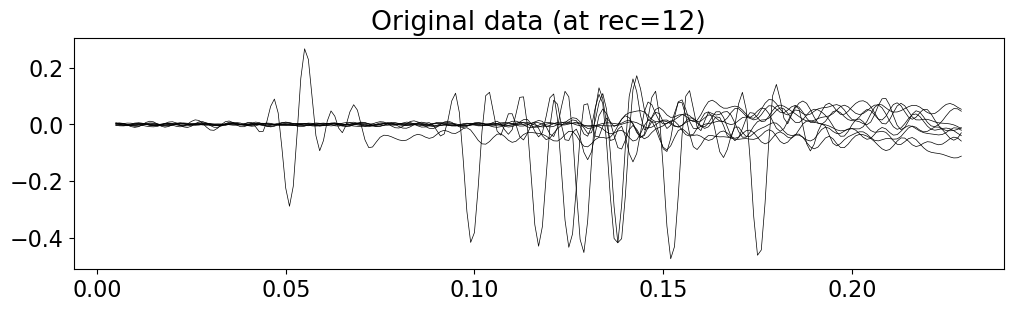

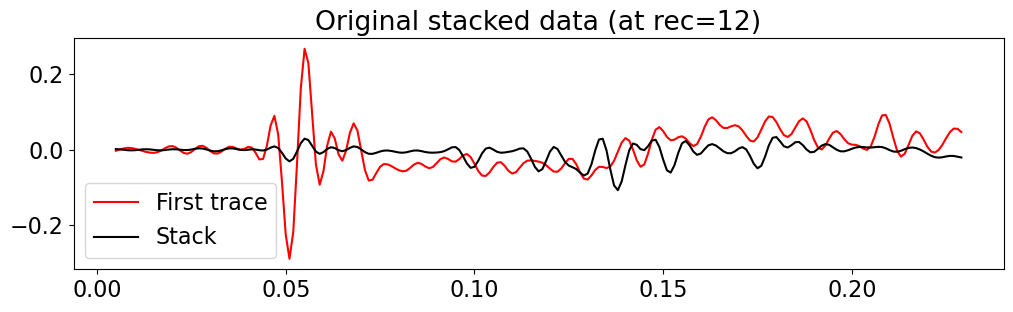

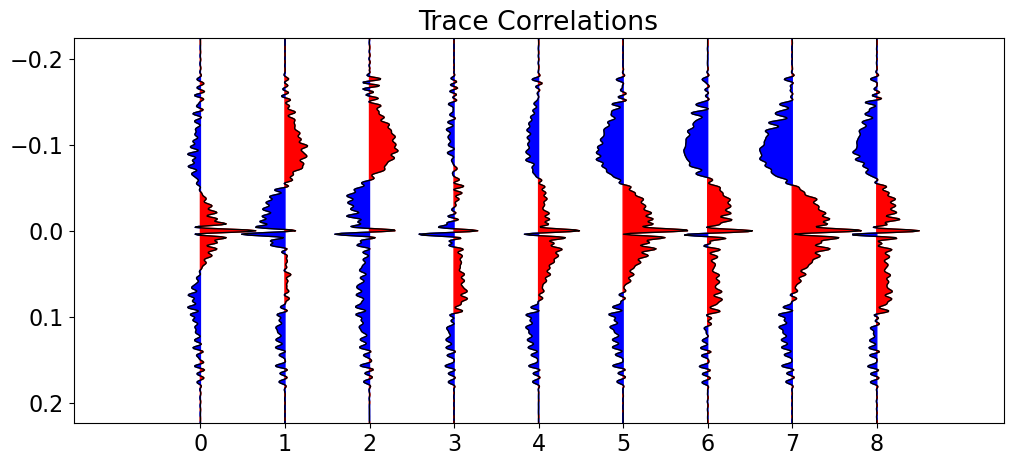

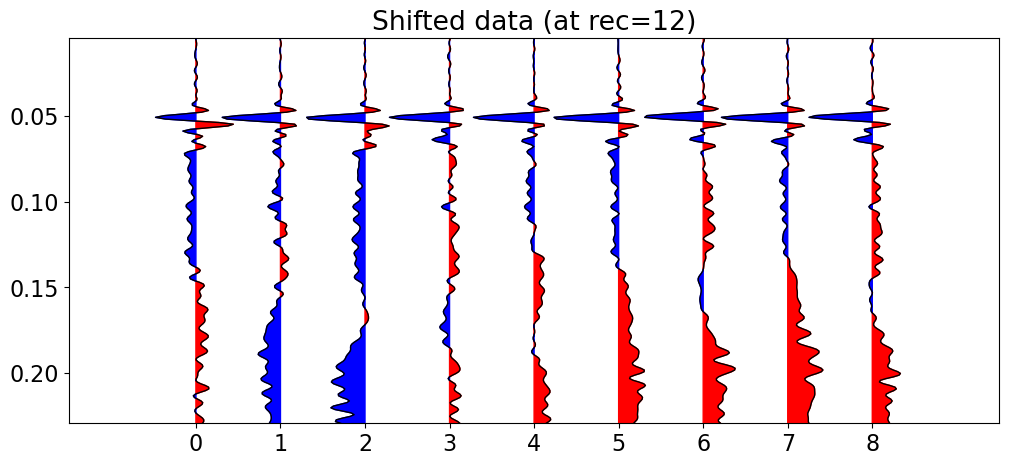

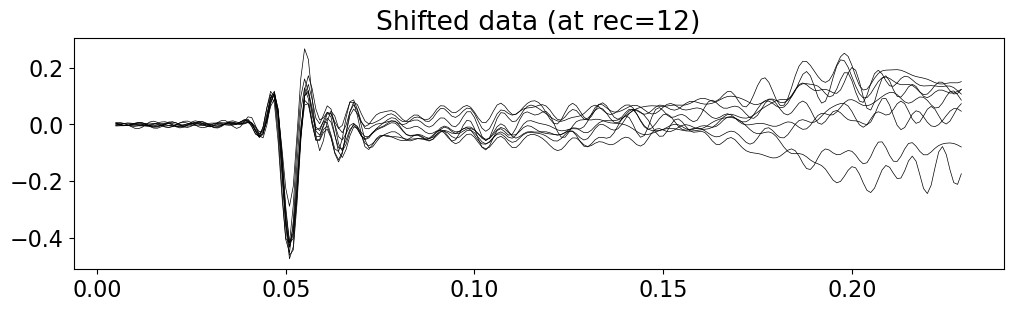

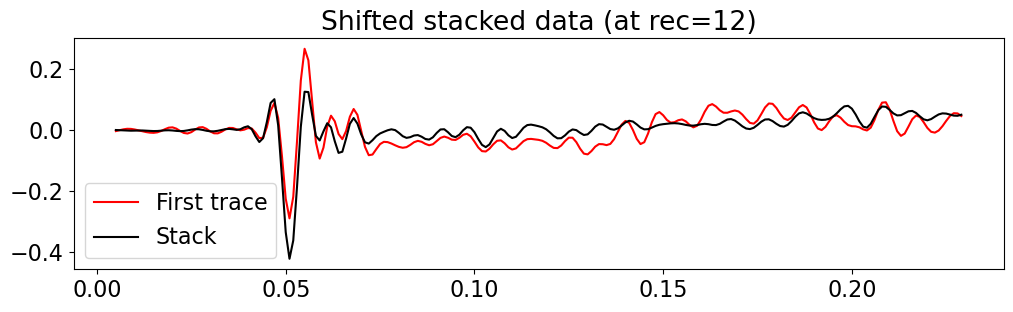

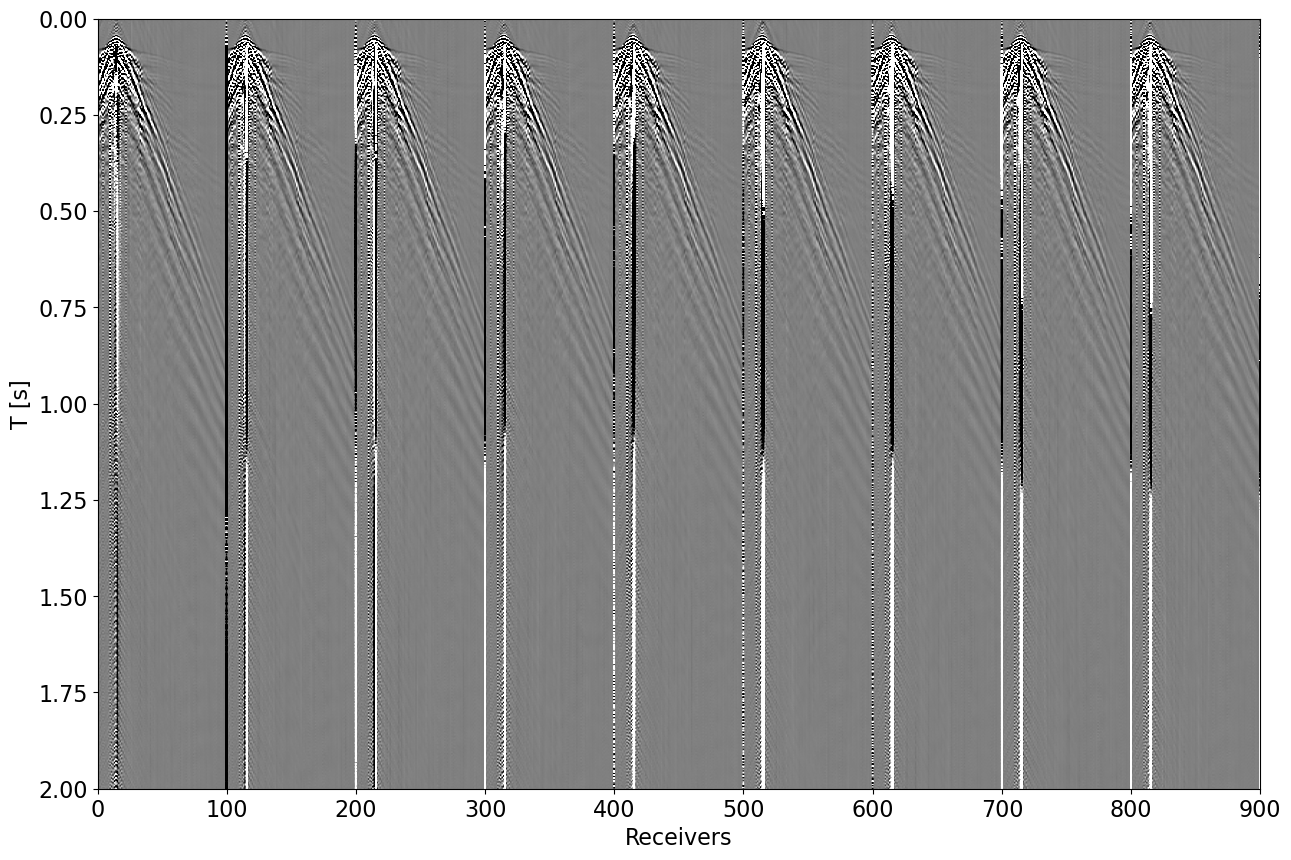

In [6]:
data = data[1:]
filtdata = filtdata[1:]
print(data.shape)
datashift, figs = aligndata(filtdata[:, 0, ishot], irecalign, fs.t, 
                            tlims=tlims, ishotmaster=ishotmaster,
                            otherdata=data[:, 0, ishot], plotflag=True)
datashift = datashift[1]

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(datashift.reshape(-1, fs.nt).T, 
          cmap='gray', vmin=-0.01, vmax=0.01, extent=(0, 90*10, fs.t[-1], 0))
ax.axis('tight')
ax.set_xlabel('Receivers')
ax.set_ylabel('T [s]')
ax.set_ylim(2., 0);

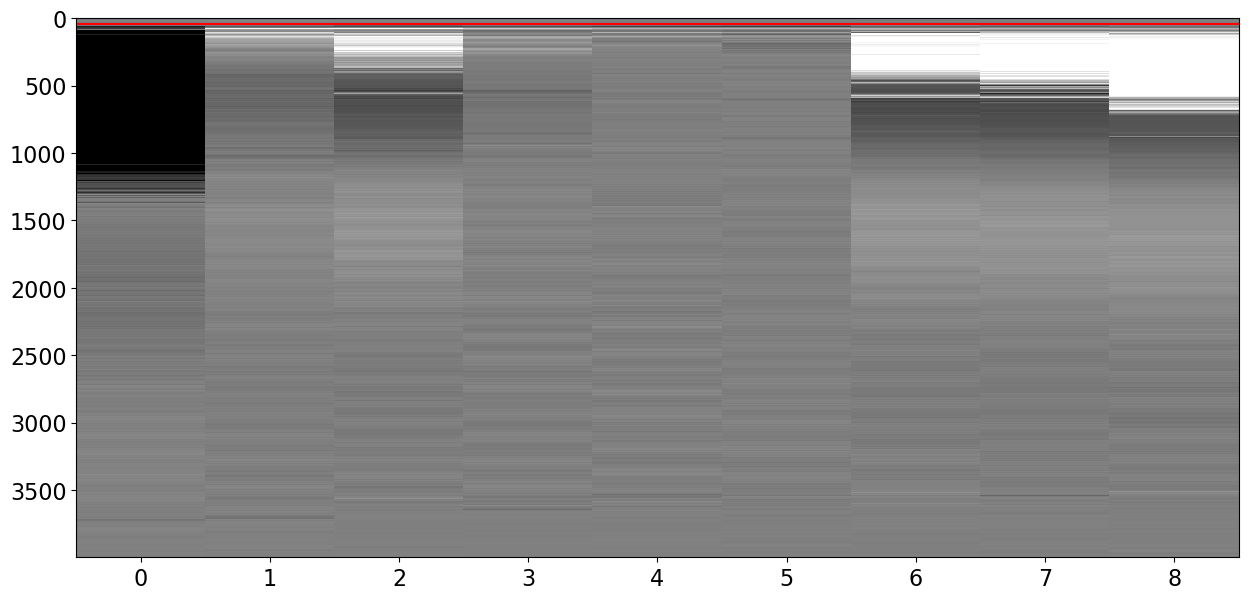

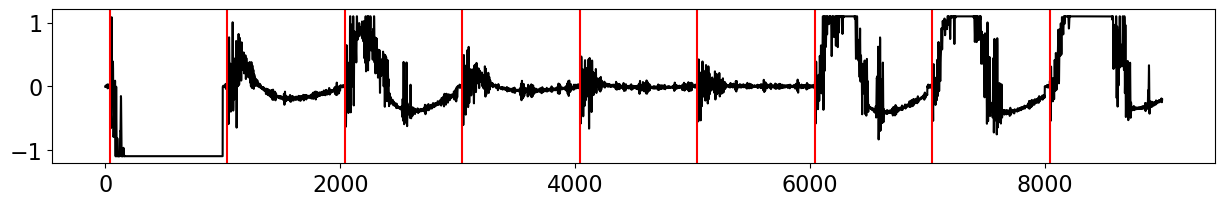

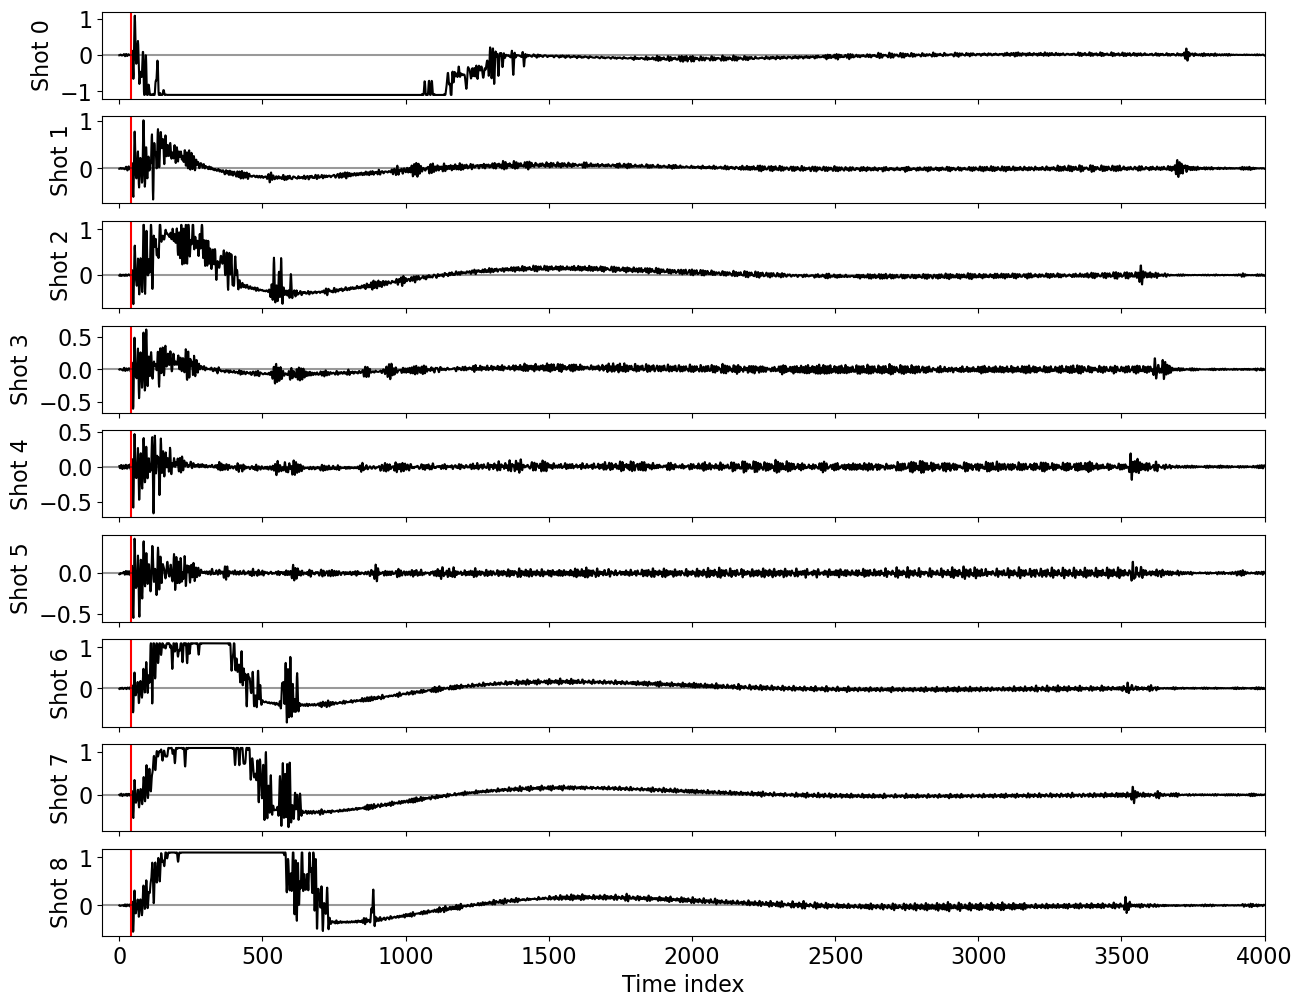

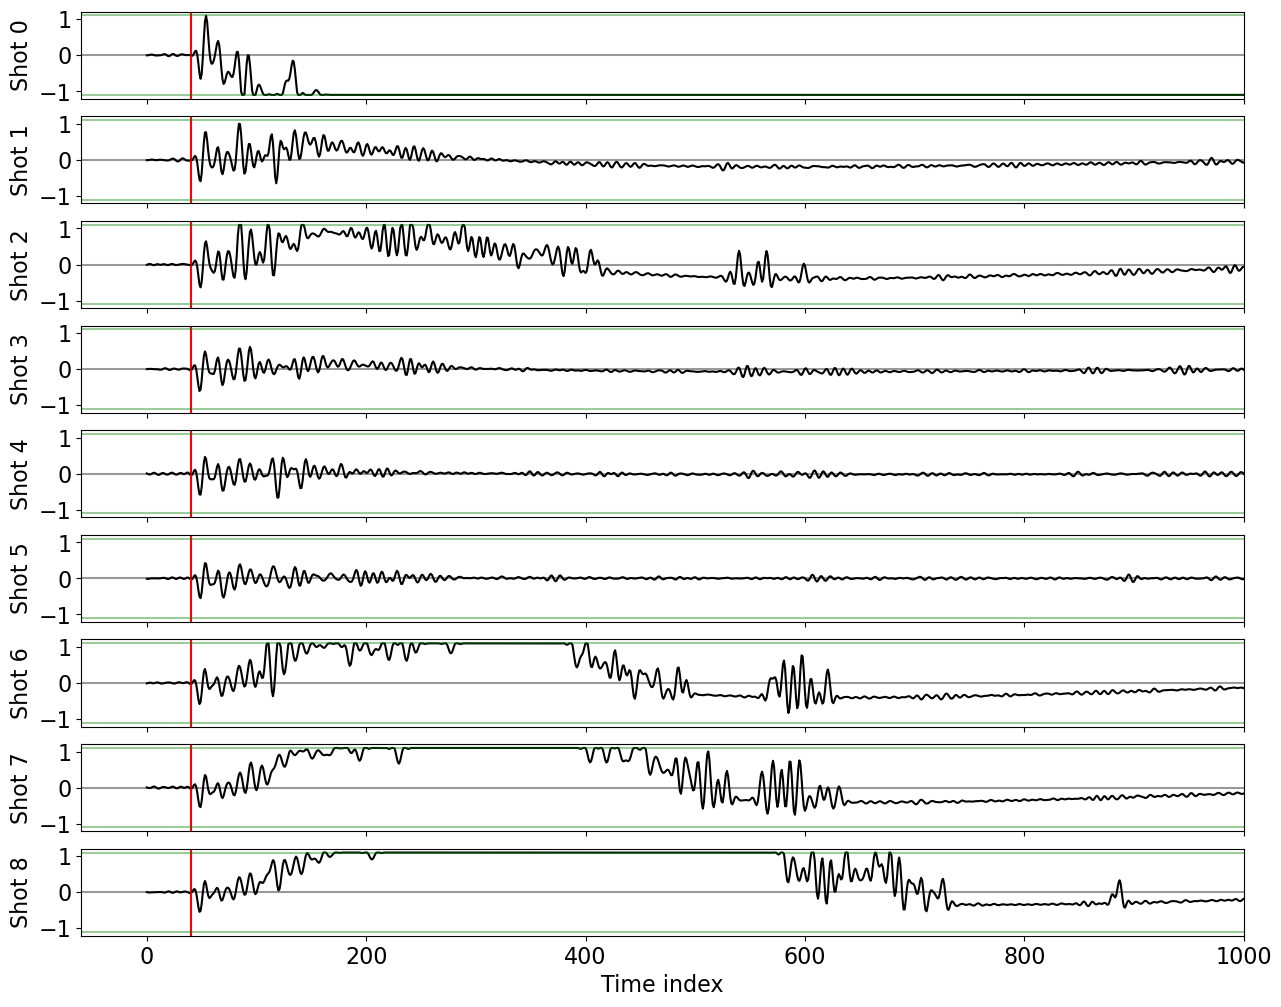

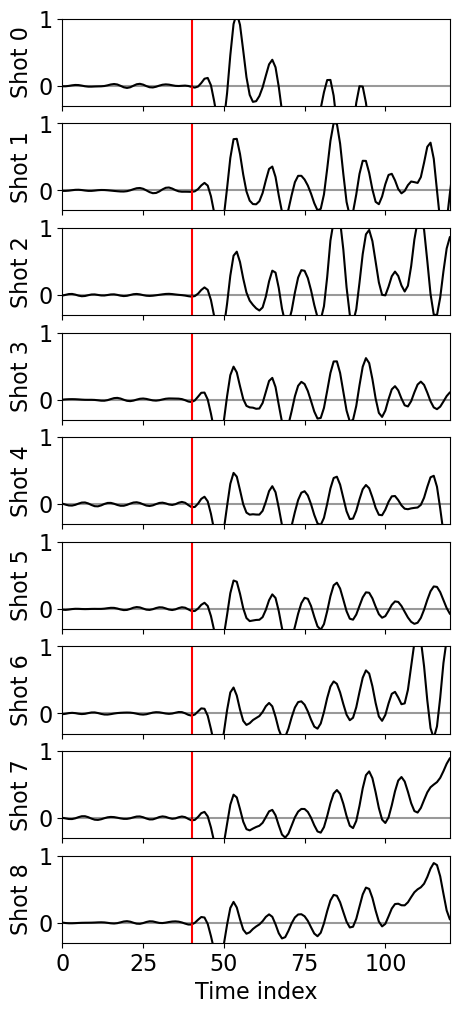

In [7]:
# Find first break of every shot
it0 = int(t0s[ishot] / fs.dt) 

plt.figure(figsize=(15,7))
plt.imshow(datashift[:, -1].T, cmap='gray', interpolation='none', vmin=-1e0, vmax=1e0)
plt.axhline(it0, c='r')
plt.axis('tight')
plt.savefig(f"Figs/Shot_{int(fs.srcpoint_axis[ishot])}_sourcesig_impng", dpi=200);

plt.figure(figsize=(15,2))
plt.plot(datashift[:, -1, :1000].ravel(), 'k')
for i in range(datashift.shape[0]): 
    plt.axvline(it0 + i * 1000, c='r')
plt.savefig(f"Figs/Shot_{int(fs.srcpoint_axis[ishot])}_sourcesig_cont.png", dpi=200);

fig, axs = plt.subplots(datashift.shape[0], sharex=True, figsize=(15, 12))
for i in range(datashift.shape[0]): 
    axs[i].plot(datashift[i, -1].ravel(), 'k')
    axs[i].axvline(it0, c='r')
    axs[i].axhline(0, c='k', alpha=0.4)
    axs[i].set_ylabel(f'Shot {i}')
axs[-1].set_xlabel('Time index')
axs[-1].set_xlim(it0-100, 4000)
plt.savefig(f"Figs/Shot_{int(fs.srcpoint_axis[ishot])}_sourcesig.png", dpi=200);

fig, axs = plt.subplots(datashift.shape[0], sharex=True, figsize=(15, 12))
for i in range(datashift.shape[0]): 
    axs[i].plot(datashift[i, -1].ravel(), 'k')
    axs[i].axvline(it0, c='r')
    axs[i].axhline(0, c='k', alpha=0.4)
    axs[i].axhline(1.1, c='g', alpha=0.4)
    axs[i].axhline(-1.1, c='g', alpha=0.4)
    axs[i].set_ylabel(f'Shot {i}')
axs[-1].set_xlabel('Time index')
axs[-1].set_xlim(it0-100, 1000)
plt.savefig(f"Figs/Shot_{int(fs.srcpoint_axis[ishot])}_sourcesig_zoom.png", dpi=200);

fig, axs = plt.subplots(datashift.shape[0], sharex=True, figsize=(5, 12))
for i in range(datashift.shape[0]): 
    axs[i].plot(datashift[i, -1].ravel(), 'k')
    axs[i].axvline(it0, c='r')
    axs[i].axhline(0, c='k', alpha=0.4)
    axs[i].axhline(1.1, c='g', alpha=0.4)
    axs[i].axhline(-1.1, c='g', alpha=0.4)
    axs[i].set_ylabel(f'Shot {i}')
    axs[i].set_ylim(-0.3, 1.)
axs[-1].set_xlabel('Time index')
axs[-1].set_xlim(it0-40, it0+80);

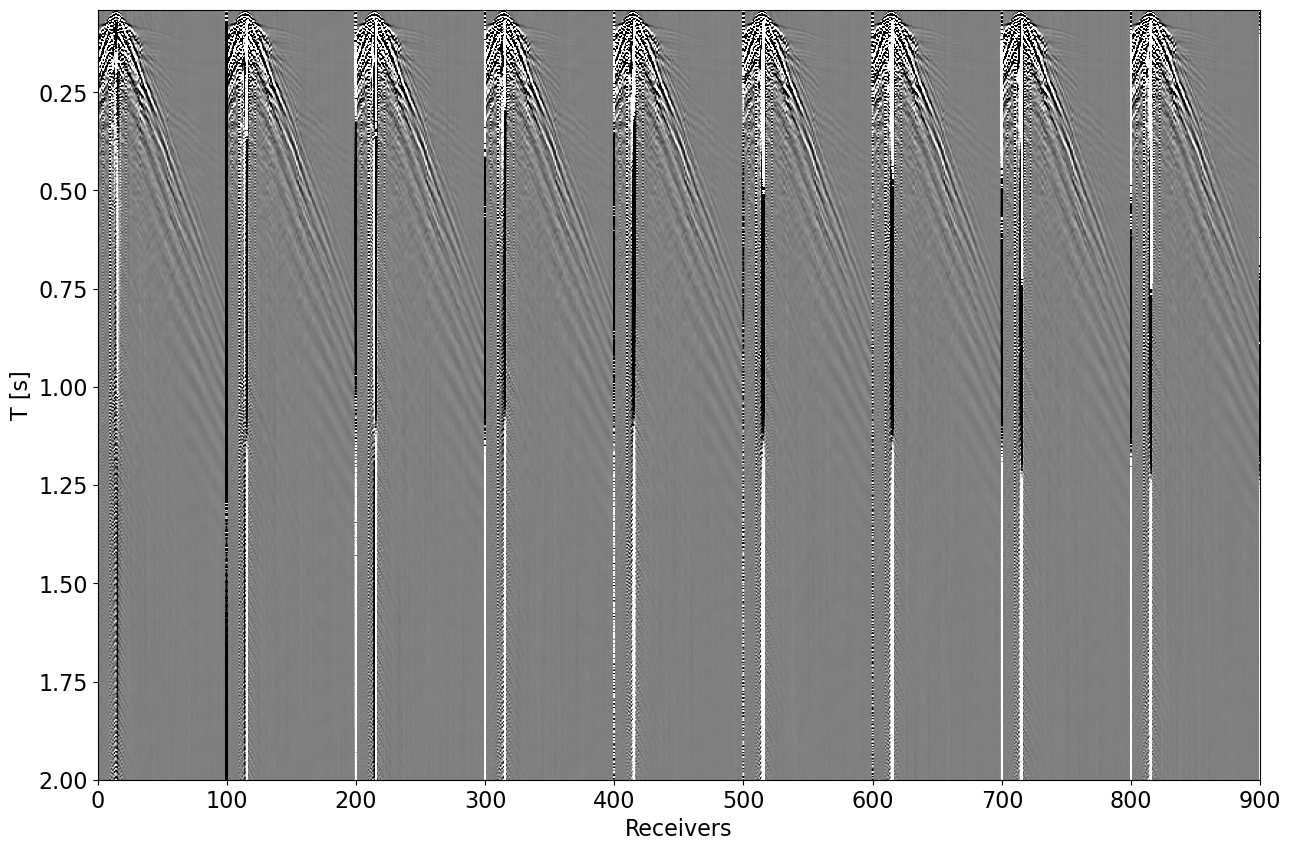

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(datashift.reshape(-1, fs.nt).T[it0:], 
          cmap='gray', vmin=-0.01, vmax=0.01, extent=(0, 90*10, fs.t[-1], fs.t[it0]))
ax.axis('tight')
ax.set_xlabel('Receivers')
ax.set_ylabel('T [s]')
ax.set_ylim(2., t0s[ishot])
plt.savefig(f"Figs/Shot_{int(fs.srcpoint_axis[ishot])}_aligned.png", dpi=200);